In [166]:
import numpy as np
import pandas as pd

In [167]:
df = pd.read_csv("NYC_2021_airbnb_reviews_data1.csv")
df.head()

,listing_id,url,review_posted_date,review
0,2595,https://www.airbnb.com/rooms/2595,November 2019,"Great location, convenient to everything. Very..."
1,2595,https://www.airbnb.com/rooms/2595,May 2019,Place was so cute and comfy! Host was great an...
2,2595,https://www.airbnb.com/rooms/2595,May 2019,10 / 10 would stay again
3,2595,https://www.airbnb.com/rooms/2595,January 2019,The apartment met expectations to how it was i...
4,2595,https://www.airbnb.com/rooms/2595,December 2018,Great space in a fun old building in NYC. Love...


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17444 entries, 0 to 17443
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   listing_id          17444 non-null  int64 
 1   url                 17444 non-null  object
 2   review_posted_date  17444 non-null  object
 3   review              17444 non-null  object
dtypes: int64(1), object(3)
memory usage: 545.2+ KB


In [169]:
id = df.listing_id.unique()
len(id)

219

In [170]:
review = df[["listing_id", "review_posted_date", "review"]]
review.head()

,listing_id,review_posted_date,review
0,2595,November 2019,"Great location, convenient to everything. Very..."
1,2595,May 2019,Place was so cute and comfy! Host was great an...
2,2595,May 2019,10 / 10 would stay again
3,2595,January 2019,The apartment met expectations to how it was i...
4,2595,December 2018,Great space in a fun old building in NYC. Love...


In [171]:
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
import re

def process(text):
    text = re.sub('[^a-zA-Z]+', ' ', text).strip()
    tokens = wordpunct_tokenize(text.lower())
    final_stopwords = stopwords.words('english') + stopwords.words('french') + stopwords.words('spanish') + stopwords.words('german')
    tokens_wo_stopwords = [t for t in tokens if t not in final_stopwords]
    text = " ".join(tokens_wo_stopwords)
    return(text)
process(review['review'][0])

'great location convenient everything cool space building'

In [172]:
review['clean_text'] = review['review'].apply(lambda text: process(text))
review.head()

,listing_id,review_posted_date,review,clean_text
0,2595,November 2019,"Great location, convenient to everything. Very...",great location convenient everything cool spac...
1,2595,May 2019,Place was so cute and comfy! Host was great an...,place cute comfy host great quick communicate ...
2,2595,May 2019,10 / 10 would stay again,would stay
3,2595,January 2019,The apartment met expectations to how it was i...,apartment met expectations insinuated ad jenni...
4,2595,December 2018,Great space in a fun old building in NYC. Love...,great space fun old building nyc loved lightin...


In [173]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
text = review['clean_text'][46]
print(text)
analyzer.polarity_scores(text)
analyzer.polarity_scores(" ")

hebben genoten van ons verblijf het appartement van jennifer prima centraal gelegen ook v openbaar vervoer het daklicht maakt dat het prettig licht ruim aanvoelt enige minpuntje vier trappen


{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

In [174]:
review['review_score_cleaned'] = review['clean_text'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
review.head()

,listing_id,review_posted_date,review,clean_text,review_score_cleaned
0,2595,November 2019,"Great location, convenient to everything. Very...",great location convenient everything cool spac...,0.7506
1,2595,May 2019,Place was so cute and comfy! Host was great an...,place cute comfy host great quick communicate ...,0.9432
2,2595,May 2019,10 / 10 would stay again,would stay,0.0000
3,2595,January 2019,The apartment met expectations to how it was i...,apartment met expectations insinuated ad jenni...,0.7506
4,2595,December 2018,Great space in a fun old building in NYC. Love...,great space fun old building nyc loved lightin...,0.9062


In [175]:
review.drop('review', axis=1, inplace=True)

In [176]:
review.to_csv("reviews_with_sentiment.csv", header=False, index=False)

<AxesSubplot: >

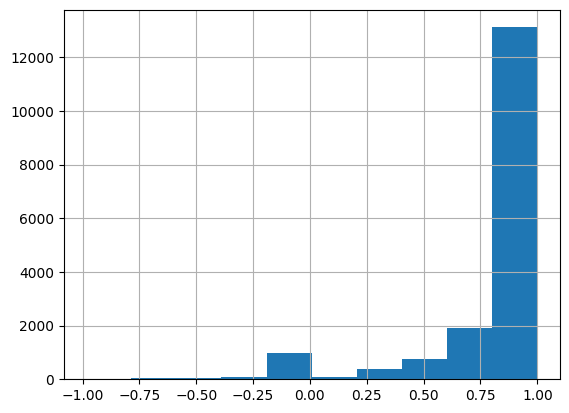

In [177]:
import matplotlib as plt
review["review_score_cleaned"].hist()

!python sentiment_month_and_year.py -r local reviews_with_sentiment.csv --no-bootstrap-mrjob

Addon
1. mapreduce: look for the average (min and max too?) review_score_cleaned (sentiment) of each listing
2. mapreduce: look for the average review_score_cleaned of each month and year
3. mapreduce: ... of each month only
4. box plot of the review_score_cleaned of each listing
5. line graph of review_score_cleaned vs review_posted_date of each listing

In [178]:
%%file sentiment_listing.py
from mrjob.job import MRJob

class SentimentListing(MRJob):

    def mapper(self, _,line):
        val=line.split(',')
        listing_id = int(val[0])
        rsc = float(val[3])
        if rsc <= 1 and rsc >= -1:
            yield listing_id, rsc

    def reducer(self, key, values):
        count =0
        total =0
        max =-1
        min = 1

        for t in values:
            count = count + 1
            total += t
            if(t>max):
                max = t
            if(t<min):
                min = t
        yield key , {"average":(total /count), "max":max, "min":min}


if __name__ == '__main__':
    SentimentListing.run()

Overwriting sentiment_listing.py


In [179]:
!python sentiment_listing.py -r local reviews_with_sentiment.csv --no-bootstrap-mrjob > listing.txt

No configs found; falling back on auto-configuration
No configs specified for local runner
Creating temp directory C:\Users\wkwan\AppData\Local\Temp\sentiment_listing.wkwan.20221216.055026.334946
Running step 1 of 1...
job output is in C:\Users\wkwan\AppData\Local\Temp\sentiment_listing.wkwan.20221216.055026.334946\output
Streaming final output from C:\Users\wkwan\AppData\Local\Temp\sentiment_listing.wkwan.20221216.055026.334946\output...
Removing temp directory C:\Users\wkwan\AppData\Local\Temp\sentiment_listing.wkwan.20221216.055026.334946...


In [180]:
%%file sentiment_month_and_year.py
from mrjob.job import MRJob
import re

DATE_RE = re.compile(r"[a-zA-Z]* [0-9]{4}")

class SentimentMonthYear(MRJob):

    def mapper(self, _, line):
        val = line.split(',')
        (review_posted_date, review_score_cleaned) = (val[1].strip(), float(val[3]))
        if (re.match(DATE_RE, review_posted_date) and (-1 <= review_score_cleaned <= 1)):
            yield review_posted_date, review_score_cleaned

    def reducer(self, key, values):
        total = 0.0
        count = 0
        max = -1
        min = 1
        for value in values:
            total += value
            count += 1
            if(value > max):
                max = value
            if(value < min):
                min = value
        yield key, {"average":(total / count), "max":max, "min":min}

if __name__ == '__main__':
    SentimentMonthYear.run()

Overwriting sentiment_month_and_year.py


In [181]:
!python sentiment_month_and_year.py -r local reviews_with_sentiment.csv --no-bootstrap-mrjob > month_year.txt

No configs found; falling back on auto-configuration
No configs specified for local runner
Creating temp directory C:\Users\wkwan\AppData\Local\Temp\sentiment_month_and_year.wkwan.20221216.055034.517999
Running step 1 of 1...
job output is in C:\Users\wkwan\AppData\Local\Temp\sentiment_month_and_year.wkwan.20221216.055034.517999\output
Streaming final output from C:\Users\wkwan\AppData\Local\Temp\sentiment_month_and_year.wkwan.20221216.055034.517999\output...
Removing temp directory C:\Users\wkwan\AppData\Local\Temp\sentiment_month_and_year.wkwan.20221216.055034.517999...


In [182]:
%%file sentiment_month.py
from mrjob.job import MRJob
import re

DATE_RE = re.compile(r"[a-zA-Z]* [0-9]{4}")

class SentimentMonth(MRJob):

    def mapper(self, _, line):
        val = line.split(',')
        (review_posted_date, review_score_cleaned) = (val[1].strip(), float(val[3]))
        if (re.match(DATE_RE, review_posted_date) and (-1 <= review_score_cleaned <= 1)):
            month = review_posted_date.split()[0]
            yield month, review_score_cleaned

    def reducer(self, key, values):
        total = 0.0
        count = 0
        max = -1
        min = 1
        for value in values:
            total += value
            count += 1
            if(value > max):
                max = value
            if(value < min):
                min = value
        yield key, {"average":(total / count), "max":max, "min":min}

if __name__ == '__main__':
    SentimentMonth.run()

Overwriting sentiment_month.py


In [183]:
!python sentiment_month.py -r local reviews_with_sentiment.csv --no-bootstrap-mrjob > month.txt

No configs found; falling back on auto-configuration
No configs specified for local runner
Creating temp directory C:\Users\wkwan\AppData\Local\Temp\sentiment_month.wkwan.20221216.055041.855953
Running step 1 of 1...
job output is in C:\Users\wkwan\AppData\Local\Temp\sentiment_month.wkwan.20221216.055041.855953\output
Streaming final output from C:\Users\wkwan\AppData\Local\Temp\sentiment_month.wkwan.20221216.055041.855953\output...
Removing temp directory C:\Users\wkwan\AppData\Local\Temp\sentiment_month.wkwan.20221216.055041.855953...


In [184]:
%%file sentiment_words.py
from mrjob.job import MRJob

class SentimentWords(MRJob):

    def mapper(self, _, line):
        val = line.split(',')
        (clean_text, review_score_cleaned) = (val[2].strip(), float(val[3]))
        if ((len(clean_text) > 0) and (-1 <= review_score_cleaned <= 1)):
            frequency = {}
            words = clean_text.split()
            for word in words:
                if len(word) > 1:
                    if word in frequency.keys():
                        frequency[word] += 1
                    else:
                        frequency[word] = 1
            sentiment = "positive"
            if review_score_cleaned <= -0.05:
                sentiment = "negative"
            elif review_score_cleaned < 0.05:
                sentiment = "neutral"
            frequency = dict(sorted(frequency.items(),
                                key=lambda item: item[1], reverse=True))
            yield sentiment, frequency

    def reducer(self, key, values):
        total_frequency = {}
        for frequency in values:
            for word in frequency:
                if word in total_frequency.keys():
                    total_frequency[word] += frequency[word]
                else:
                    total_frequency[word] = frequency[word]
        total_frequency = dict(filter(lambda item: item[1] > 1, total_frequency.items()))
        total_frequency = dict(sorted(total_frequency.items(),
                                key=lambda item: item[1], reverse=True))
        yield key, total_frequency

if __name__ == '__main__':
    SentimentWords.run()

Overwriting sentiment_words.py


In [185]:
!python sentiment_words.py -r local reviews_with_sentiment.csv --no-bootstrap-mrjob > words.txt

No configs found; falling back on auto-configuration
No configs specified for local runner
Creating temp directory C:\Users\wkwan\AppData\Local\Temp\sentiment_words.wkwan.20221216.055049.109812
Running step 1 of 1...
job output is in C:\Users\wkwan\AppData\Local\Temp\sentiment_words.wkwan.20221216.055049.109812\output
Streaming final output from C:\Users\wkwan\AppData\Local\Temp\sentiment_words.wkwan.20221216.055049.109812\output...
Removing temp directory C:\Users\wkwan\AppData\Local\Temp\sentiment_words.wkwan.20221216.055049.109812...
